# **Thesis: "Integration of Energy-based generative learning and Neural Network classification"** - Colombo Irene Maria

# **Imports**

Importing all the libraries I will need.

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import random
import os
import matplotlib.pyplot as plt
import scienceplots
from torch.optim import AdamW
from copy import deepcopy

In [18]:
plt.style.use(['science','no-latex'])

Use GPU if available

In [19]:
torch.backends.mps.is_available()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device}")

Using mps


# **Dataset**

Download MNIST and creating tensors.

In [20]:
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [21]:
batch_size = 256

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

A $\texttt{set\_random\_seed}$ function is defined to avoid randomness.

In [22]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Restricted Boltzmann Machine**

Implementation of the Restricted Boltmann Machine: it takes as inputs visible layer and hidden layer, number of Gibbs sampling, initial bias and weights (initialized at 0 if not given) <br>



In [23]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid=128, k=5, init_weights=None, device='cpu'):
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis).to(device))
        self.h = nn.Parameter(torch.randn(1, n_hid).to(device))
        if init_weights is not None:
            assert init_weights.shape == (n_hid, n_vis)
            self.W = nn.Parameter(init_weights.to(device))
        else:
            self.W = nn.Parameter(torch.rand(n_hid, n_vis).to(device))
        self.k = k
        self.device = device

    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        v = v.to(self.device) 
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v, v_gibb
    
    def get_hidden_units(self, v):
        v = v.to(self.device)
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v)
        return h

Coputing initial metrics (free energy, loss) to understand better what happens since the first step of the RBM.

In [24]:
def compute_initial_metrics(model, data_loader, neural_network, device):
    model.eval()
    with torch.no_grad():
        for batch, (data, _) in enumerate(data_loader):
            data = data.to(device)
            hidden_activations = neural_network.get_hidden_units(data)

            v_pos = hidden_activations
            h_pos_prob = model.visible_to_hidden(v_pos)
            h_pos = h_pos_prob.bernoulli()

            v_neg = model.hidden_to_visible(h_pos)
            h_neg_prob = model.visible_to_hidden(v_neg)

            positive_phase = torch.matmul(v_pos.t(), h_pos_prob)
            negative_phase = torch.matmul(v_neg.t(), h_neg_prob)
            initial_cd_loss = torch.mean(negative_phase - positive_phase) 

            free_energy_v = model.free_energy(v_pos)
            free_energy_v_neg = model.free_energy(v_neg)
            initial_free_energy_diff = torch.mean(free_energy_v - free_energy_v_neg)

            return initial_cd_loss, initial_free_energy_diff

Defining the training function for the RBM

In [25]:
def train_rbm(model, train_loader, neural_network, n_epochs, lr, patience=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    neural_network.to(device)
    train_op = AdamW(model.parameters(), lr, weight_decay=1e-5)
    model.train()
    neural_network.eval() 

    initial_loss, initial_free_energy_diff = compute_initial_metrics(model, train_loader, neural_network, device)
    print(f"Initial Loss: {initial_loss.item():.6f}, Initial Free Energy Difference: {initial_free_energy_diff.item():.6f}")

    train_losses_r = [initial_loss.item()] 
    free_energy_diffs = [initial_free_energy_diff.item()]  
    best_free_energy_diff = initial_free_energy_diff.item()
    no_improve_epoch = 0

    visible_units_activations = []

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        epoch_free_energy_diff = 0.0
        total_batches = len(train_loader)

        for batch, (data, _) in enumerate(train_loader):
            data = data.to(device)
            hidden_activations = neural_network.get_hidden_units(data)

            v_pos = hidden_activations
            h_pos_prob = model.visible_to_hidden(v_pos)
            h_pos = h_pos_prob.bernoulli()
            v_neg = model.hidden_to_visible(h_pos)
            h_neg_prob = model.visible_to_hidden(v_neg)
            cd_loss = torch.mean(torch.matmul(v_neg.t(), h_neg_prob) - torch.matmul(v_pos.t(), h_pos_prob))
            free_energy_v = model.free_energy(v_pos)
            free_energy_v_neg = model.free_energy(v_neg)
            free_energy_diff = free_energy_v - free_energy_v_neg

            train_op.zero_grad()
            cd_loss.backward()
            train_op.step()

            epoch_loss += cd_loss.item()
            epoch_free_energy_diff += free_energy_diff.item()

            visible_units_activations.append(v_neg.cpu().detach().numpy())

        epoch_loss /= total_batches
        epoch_free_energy_diff /= total_batches
        train_losses_r.append(epoch_loss)
        free_energy_diffs.append(epoch_free_energy_diff)

        print(f"Epoch {epoch+1}: Avg Loss: {epoch_loss:.10f}, Avg Free Energy Diff: {epoch_free_energy_diff:.6f}")

        if epoch_free_energy_diff < best_free_energy_diff:
            best_free_energy_diff = epoch_free_energy_diff
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
        
        if no_improve_epoch >= patience:
            print("Stopping early due to no improvement in free energy difference")
            break

    return model, train_losses_r, free_energy_diffs, visible_units_activations

# **Simple Neural Network**

A shallow Neural Network is defined, taking an input of 28*28 and with a hidden layer of size 256

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.hidden_activations = None

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        self.hidden_activations = x 
        x = self.fc2(x)
        return x
    
    def get_hidden_units(self, x):
        with torch.no_grad():
            _ = self.forward(x)
        return self.hidden_activations


In [49]:
set_random_seed(42)
model_1 = NeuralNetwork().to(device)
model_1

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

The CrossEntropy is chosen as loss, and Adam as optimizer

In [50]:
loss_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 1e-3)

## **Training and testing**

The training and testing function for the NN are defined:

In [29]:
def train_nn(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    model.to(device)
    train_loss = 0.0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"[{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    correct /= size
    print(f"TRAINING - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {loss:>7f}")
    return 100*correct, train_loss

def test_nn(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct/= size
    print(f"TESTING - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct, test_loss

The model is trained, for 20 epochs

In [51]:
train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

set_random_seed(42)
epochs = 20
for t in range(epochs):
    print(f"Epoch {t + 1} \n ----------")
    train_acc, train_loss = train_nn(train_dataloader, model_1, loss_1, optimizer)
    test_acc, test_loss = test_nn(test_dataloader, model_1, loss_1)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("Done!")

Epoch 1 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  88.6%, Avg loss: 0.246655
TESTING - Accuracy:  93.4%, Avg loss: 0.228849

Done!
Epoch 2 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  94.4%, Avg loss: 0.148755
TESTING - Accuracy:  95.2%, Avg loss: 0.163014

Done!
Epoch 3 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  95.9%, Avg loss: 0.074143
TESTING - Accuracy:  96.0%, Avg loss: 0.127118

Done!
Epoch 4 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  96.9%, Avg loss: 0.152311
TESTING - Accuracy:  96.6%, Avg loss: 0.112355

Done!
Epoch 5 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  97.4%, Avg loss: 0.054905
TESTING - Accuracy:  97.1%, Avg loss: 0.093356

Done!
Epoch 6 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  97.9%, Avg loss: 0.068917
TESTING - Accuracy:  97.4%, Avg loss: 0.085519

Done!
Epoch 7 
 

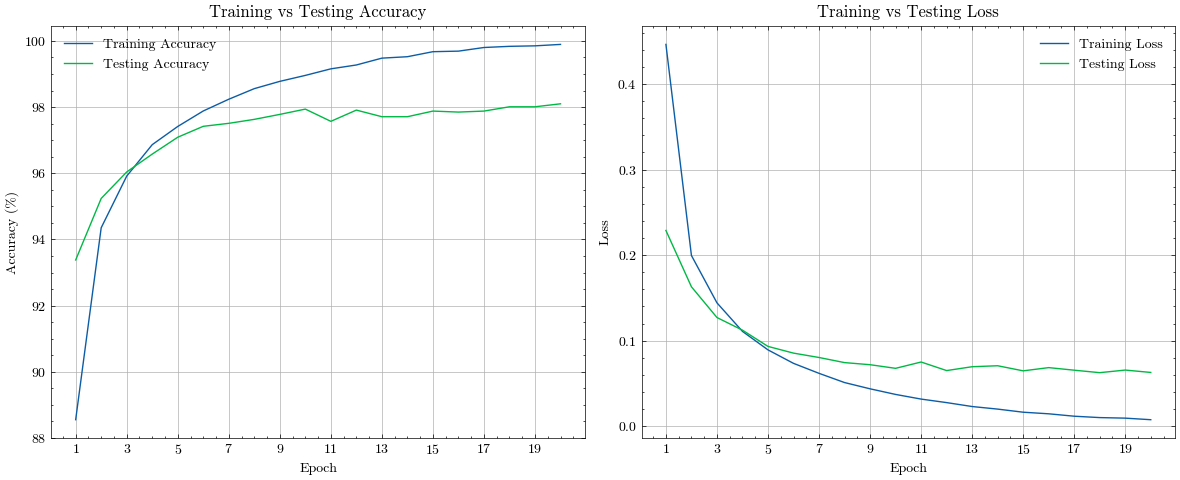

In [59]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label = 'Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label = 'Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, epochs + 1, 2)) 
plt.legend()
plt.grid(True) 


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs + 1, 2))
plt.legend()
plt.grid(True) 

plt.tight_layout()
plt.show()

It can be seen that the model achieves very good results, even with just one-hidden layer and 20 epochs. This will be considered as a baseline for the integrated model.

## Save model's parameters

The hidden layer activations are saved here, to be used in the next section as inputs (visible layers) for the RBM.

### Hidden layer

In [32]:
sample_data, _ = next(iter(train_dataloader))  
sample_data = sample_data.to(device)
hidden_units = model_1.get_hidden_units(sample_data)

# **RBM inclusion**

Here, after saving the hidden units of the one-layer Neural Network, they are used to set the number of visible units that the RBM has to contain

In [33]:
hidden_units.size(1)

256

In [34]:
num_epochs = 5
set_random_seed(42)
rbm = RBM(n_vis=hidden_units.size(1), n_hid=1000, k=5) 

Here the training start. The function $\texttt{train\_rbm}$ retrieves automatically the hidden units' activations from $\texttt{model\_1}$ and uses them as visible layer.

Initial Loss: 19.294891, Initial Free Energy Difference: 9611.812500
Epoch 1: Avg Loss: 17.1248998764, Avg Free Energy Diff: 8565.943517
Epoch 2: Avg Loss: 17.1249000184, Avg Free Energy Diff: 8556.795013
Epoch 3: Avg Loss: 17.1249001523, Avg Free Energy Diff: 8555.002427
Epoch 4: Avg Loss: 17.1249004060, Avg Free Energy Diff: 8557.908145
Epoch 5: Avg Loss: 17.1249005318, Avg Free Energy Diff: 8558.872540
Epoch 6: Avg Loss: 17.1249004587, Avg Free Energy Diff: 8554.935805
Epoch 7: Avg Loss: 17.1249003512, Avg Free Energy Diff: 8553.728956
Epoch 8: Avg Loss: 17.1249002071, Avg Free Energy Diff: 8551.325731
Epoch 9: Avg Loss: 17.1249003826, Avg Free Energy Diff: 8544.258710
Epoch 10: Avg Loss: 17.1249002518, Avg Free Energy Diff: 8550.977327


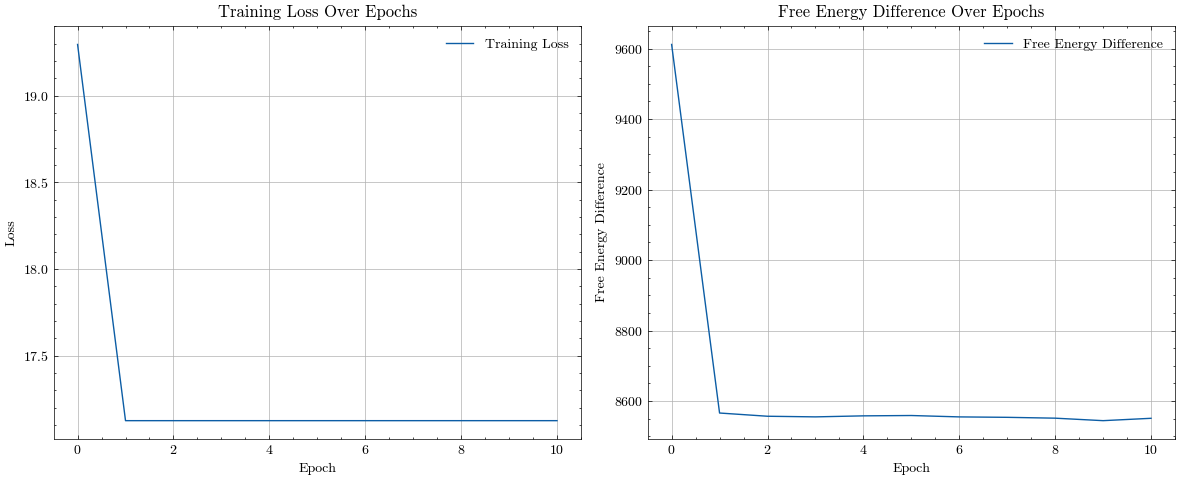

In [60]:
set_random_seed(42)

rbm, train_losses_r, free_energy_diffs, visible_units_activations = train_rbm(rbm, train_dataloader, model_1, n_epochs=10, lr=1e-6)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_r, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.plot(free_energy_diffs, label='Free Energy Difference')
plt.xlabel('Epoch')
plt.ylabel('Free Energy Difference')
plt.title('Free Energy Difference Over Epochs')
plt.legend()
plt.grid(True) 

plt.tight_layout()
plt.show()

An immediate good performance can be seen on the first epoch. however, the following epochs don't do much: it look like the RBM reaches immediately a "equilibrium" and cannot get better.

## **More of rbm**

Here, to investigate if the RBM can have a better performance, different seeds and different learning rates are chosen.

In [36]:
def initialize_rbm(n_vis, n_hid, k):
    torch.manual_seed(42)
    model = RBM(n_vis, n_hid, k)
    return model

Training with learning rate: 0.001
Initial Loss: 19.294891, Initial Free Energy Difference: 9611.812500
Epoch 1: Avg Loss: 17.1248998764, Avg Free Energy Diff: 8565.943517
Epoch 2: Avg Loss: 17.1249000184, Avg Free Energy Diff: 8556.795013
Epoch 3: Avg Loss: 17.1249001523, Avg Free Energy Diff: 8555.002427
Epoch 4: Avg Loss: 17.1249004060, Avg Free Energy Diff: 8557.908145
Epoch 5: Avg Loss: 17.1249005318, Avg Free Energy Diff: 8558.872540
Epoch 6: Avg Loss: 17.1249004587, Avg Free Energy Diff: 8554.935805
Epoch 7: Avg Loss: 17.1249003512, Avg Free Energy Diff: 8553.728956
Epoch 8: Avg Loss: 17.1249002071, Avg Free Energy Diff: 8551.325731
Epoch 9: Avg Loss: 17.1249003826, Avg Free Energy Diff: 8544.258710
Epoch 10: Avg Loss: 17.1249002518, Avg Free Energy Diff: 8550.977327
Training with learning rate: 0.0001
Initial Loss: 19.294891, Initial Free Energy Difference: 9611.812500
Epoch 1: Avg Loss: 17.1248998764, Avg Free Energy Diff: 8565.943517
Epoch 2: Avg Loss: 17.1249000184, Avg Free

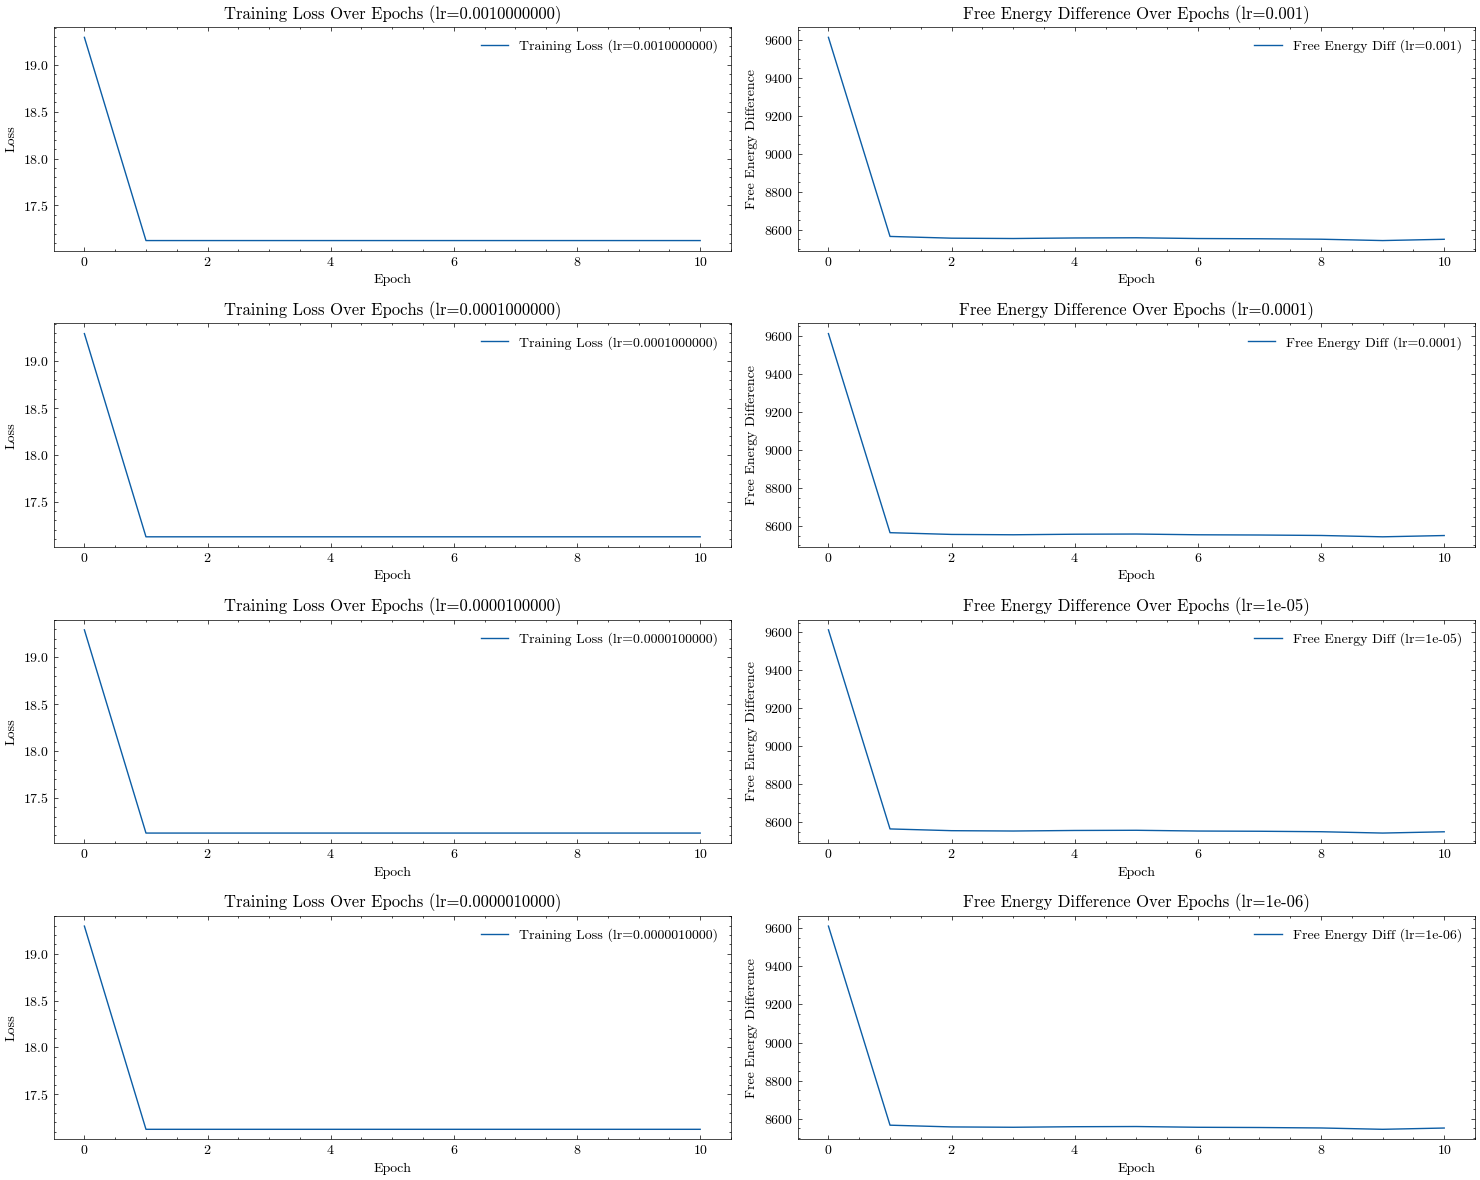

In [37]:
base_rbm = initialize_rbm(n_vis=hidden_units.size(1), n_hid=500, k=5)
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    rbm_clone = deepcopy(rbm)
    set_random_seed(42)
    rbm_lr, train_losses_1, free_energy_diffs_1, visible_units_activations_1 = train_rbm(rbm_clone, train_dataloader, model_1, n_epochs=10, lr=lr)
    results[lr] = (train_losses_1, free_energy_diffs)

plt.figure(figsize=(15, 12))

for i, lr in enumerate(learning_rates):
    train_losses_1, free_energy_diffs_1 = results[lr]

    plt.subplot(4, 2, 2*i+1)
    plt.plot(train_losses_1, label=f'Training Loss (lr={lr:.10f})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Over Epochs (lr={lr:.10f})')
    plt.legend()

    plt.subplot(4, 2, 2*i+2)
    plt.plot(free_energy_diffs_1, label=f'Free Energy Diff (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Free Energy Difference')
    plt.title(f'Free Energy Difference Over Epochs (lr={lr})')
    plt.legend()

plt.tight_layout()
plt.show()

Since it is impossible to see if energy and loss oscillate after the first epoch because the difference between the starting point and the first epoch is too large, let's take away the initial parameters. 

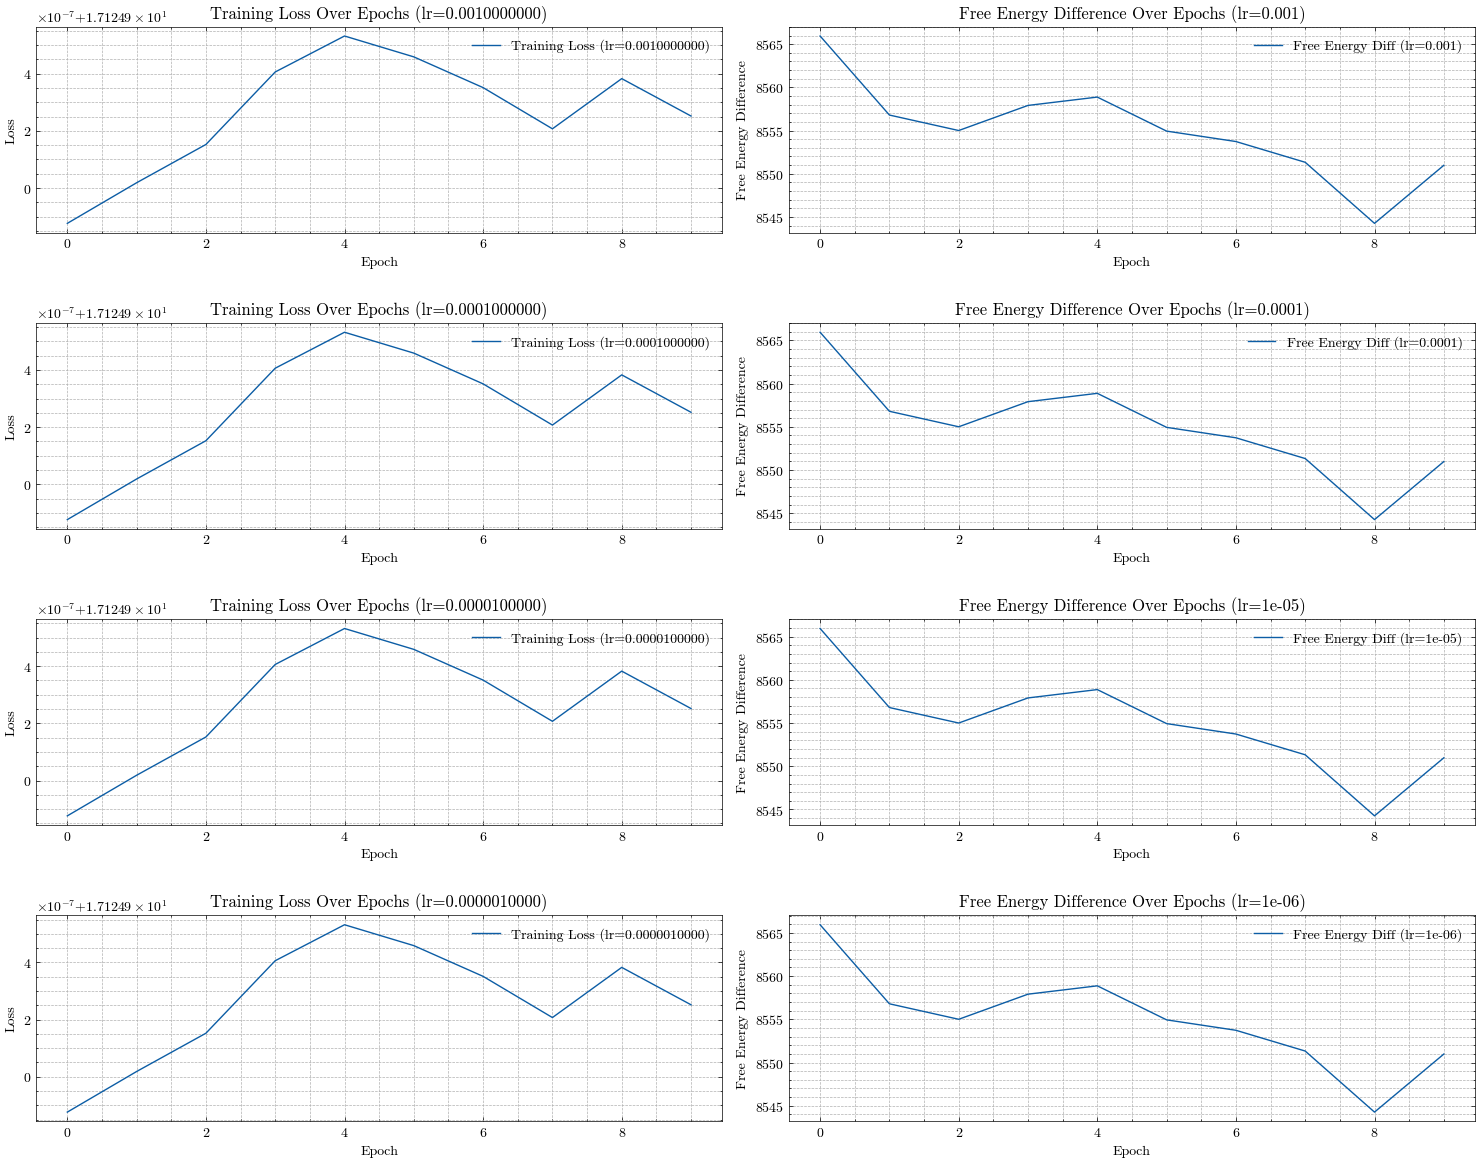

In [38]:
plt.figure(figsize=(15, 12))

for i, lr in enumerate(learning_rates):
    train_losses_1, free_energy_diffs_1 = results[lr]

    train_losses_1 = train_losses_1[1:]
    free_energy_diffs_1 = free_energy_diffs_1[1:]

    plt.subplot(4, 2, 2*i+1)
    plt.plot(train_losses_1, label=f'Training Loss (lr={lr:.10f})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Over Epochs (lr={lr:.10f})')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.subplot(4, 2, 2*i+2)
    plt.plot(free_energy_diffs_1, label=f'Free Energy Diff (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Free Energy Difference')
    plt.title(f'Free Energy Difference Over Epochs (lr={lr})')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

The model oscillates, but the learning rate has nothing to do with that. Let's see what happens with different random seeds

Training with random seed: 42
Initial Loss: 19.294891, Initial Free Energy Difference: 9611.812500
Epoch 1: Avg Loss: 17.1248998764, Avg Free Energy Diff: 8565.943517
Epoch 2: Avg Loss: 17.1249000184, Avg Free Energy Diff: 8556.795013
Epoch 3: Avg Loss: 17.1249001523, Avg Free Energy Diff: 8555.002427
Epoch 4: Avg Loss: 17.1249004060, Avg Free Energy Diff: 8557.908145
Epoch 5: Avg Loss: 17.1249005318, Avg Free Energy Diff: 8558.872540
Epoch 6: Avg Loss: 17.1249004587, Avg Free Energy Diff: 8554.935805
Epoch 7: Avg Loss: 17.1249003512, Avg Free Energy Diff: 8553.728956
Epoch 8: Avg Loss: 17.1249002071, Avg Free Energy Diff: 8551.325731
Epoch 9: Avg Loss: 17.1249003826, Avg Free Energy Diff: 8544.258710
Epoch 10: Avg Loss: 17.1249002518, Avg Free Energy Diff: 8550.977327
Training with random seed: 111
Initial Loss: 20.680964, Initial Free Energy Difference: 10313.179688
Epoch 1: Avg Loss: 17.1249005622, Avg Free Energy Diff: 8549.813630
Epoch 2: Avg Loss: 17.1249000793, Avg Free Energy D

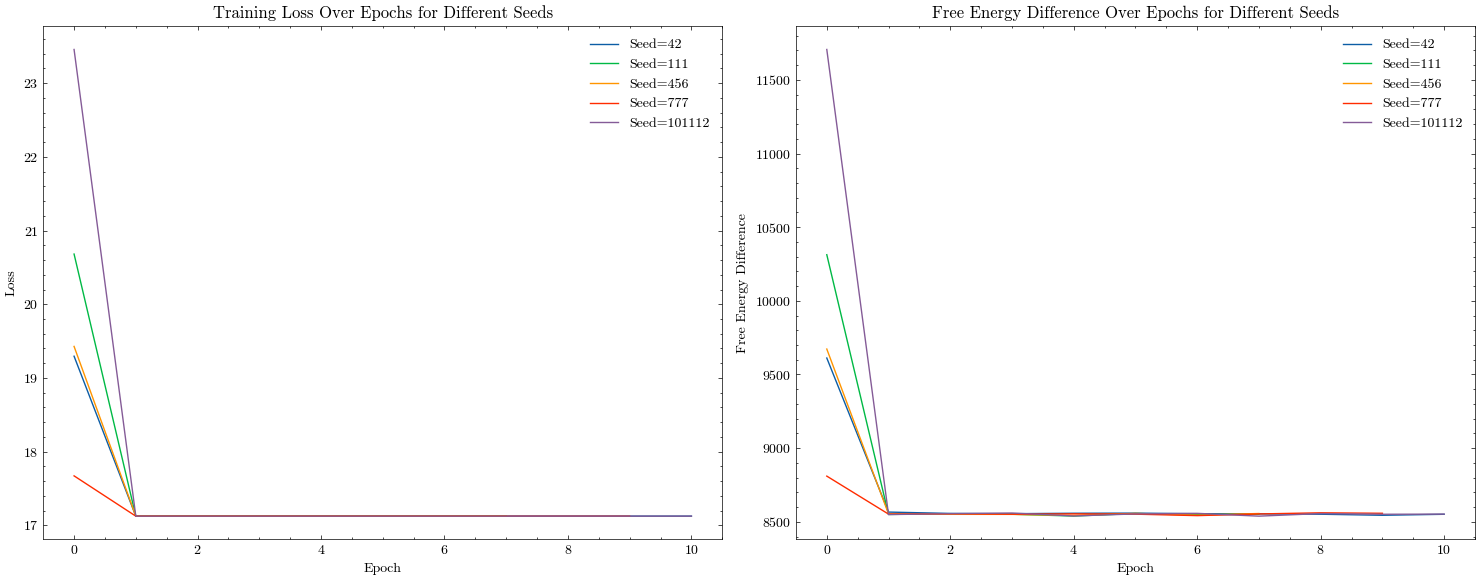

In [61]:
seeds = [42, 111, 456, 777, 101112]
learning_rate = 1e-6
results = {}

for seed in seeds:
    print(f"Training with random seed: {seed}")
    set_random_seed(seed)
    rbm_clone = deepcopy(rbm)
    rbm_seeds, train_losses_2, free_energy_diffs_2, visible_units_activations_2 = train_rbm(rbm_clone, train_dataloader, model_1, n_epochs=10, lr=1e-6)
    results[seed] = (train_losses_2, free_energy_diffs_2)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for seed in seeds:
    train_losses_2, _ = results[seed]
    plt.plot(train_losses_2, label=f'Seed={seed}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Different Seeds')
plt.legend()

plt.subplot(1, 2, 2)
for seed in seeds:
    _, free_energy_diffs_2 = results[seed]
    plt.plot(free_energy_diffs_2, label=f'Seed={seed}')
plt.xlabel('Epoch')
plt.ylabel('Free Energy Difference')
plt.title('Free Energy Difference Over Epochs for Different Seeds')
plt.legend()

plt.tight_layout()
plt.show()


The initial energy and loss differs, but as before, the machine reaches a "equilibrium" and cannot improve any further.

Initial Loss: 19.294891, Initial Free Energy Difference: 9611.812500
Epoch 1: Avg Loss: 17.1248998764, Avg Free Energy Diff: 8565.943517
Epoch 2: Avg Loss: 17.1249000184, Avg Free Energy Diff: 8556.795013
Epoch 3: Avg Loss: 17.1249001523, Avg Free Energy Diff: 8555.002427
Epoch 4: Avg Loss: 17.1249004060, Avg Free Energy Diff: 8557.908145
Epoch 5: Avg Loss: 17.1249005318, Avg Free Energy Diff: 8558.872540
Epoch 6: Avg Loss: 17.1249004587, Avg Free Energy Diff: 8554.935805
Epoch 7: Avg Loss: 17.1249003512, Avg Free Energy Diff: 8553.728956
Epoch 8: Avg Loss: 17.1249002071, Avg Free Energy Diff: 8551.325731
Epoch 9: Avg Loss: 17.1249003826, Avg Free Energy Diff: 8544.258710
Epoch 10: Avg Loss: 17.1249002518, Avg Free Energy Diff: 8550.977327


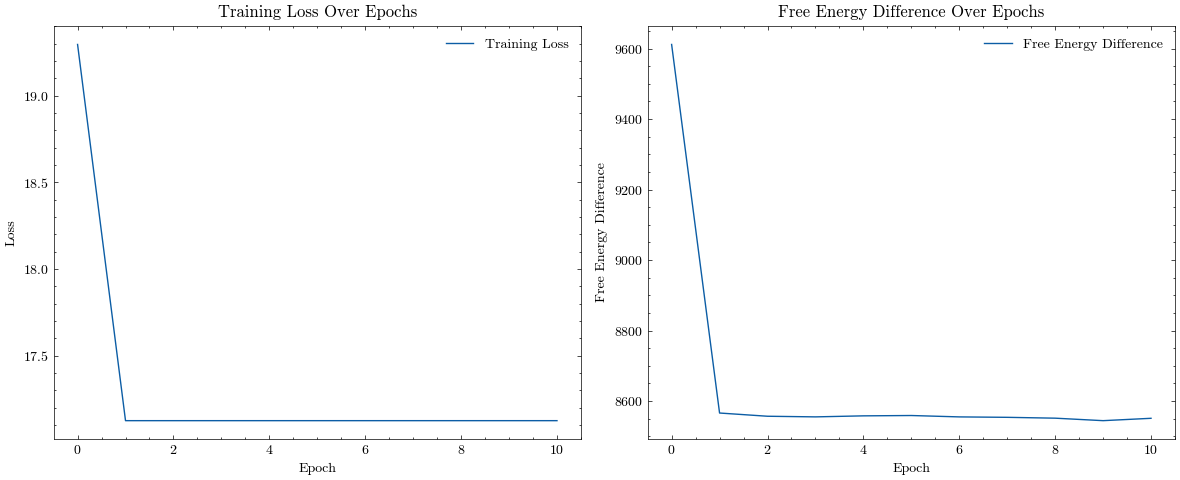

In [40]:
set_random_seed(42)
rbm, train_losses, free_energy_diffs, visible_units_activations = train_rbm(rbm, train_dataloader, model_1, n_epochs=10, lr=1e-6)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(free_energy_diffs, label='Free Energy Difference')
plt.xlabel('Epoch')
plt.ylabel('Free Energy Difference')
plt.title('Free Energy Difference Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# **New Neural Network, integration with RBM**

Here the RBM is finally integrated with the shallow Neural Network.

In [41]:
class New_NeuralNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_size=96, output_size=10):
        super(New_NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.ReLU()(self.hidden_layer(x))
        output = self.output_layer(x)
        return output

In [42]:
set_random_seed(42)
model_3 = New_NeuralNetwork().to(device)

In [43]:
loss_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_3.parameters(), lr = 1e-2)

In [44]:
train_accuracies2, test_accuracies2 = [], []
train_losses2, test_losses2 = [], []

set_random_seed(42)
epochs = 20
for t in range(epochs):
    print(f"Epoch {t + 1} \n ----------")
    train_acc2, train_loss2 = train_nn(train_dataloader, model_3, loss_2, optimizer_2)
    test_acc2, test_loss2 = test_nn(test_dataloader, model_3, loss_2)
    train_accuracies2.append(train_acc2)
    test_accuracies2.append(test_acc2)
    train_losses2.append(train_loss2)
    test_losses2.append(test_loss2)

    print("Done!")

Epoch 1 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  92.2%, Avg loss: 0.087088
TESTING - Accuracy:  95.8%, Avg loss: 0.139636

Done!
Epoch 2 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  96.6%, Avg loss: 0.147394
TESTING - Accuracy:  96.7%, Avg loss: 0.103167

Done!
Epoch 3 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  97.5%, Avg loss: 0.021614
TESTING - Accuracy:  97.0%, Avg loss: 0.099408

Done!
Epoch 4 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  97.9%, Avg loss: 0.131287
TESTING - Accuracy:  96.8%, Avg loss: 0.110852

Done!
Epoch 5 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  98.2%, Avg loss: 0.047674
TESTING - Accuracy:  97.2%, Avg loss: 0.105859

Done!
Epoch 6 
 ----------
[  256/60000]
[25856/60000]
[51456/60000]
TRAINING - Accuracy:  98.5%, Avg loss: 0.020525
TESTING - Accuracy:  97.1%, Avg loss: 0.105007

Done!
Epoch 7 
 

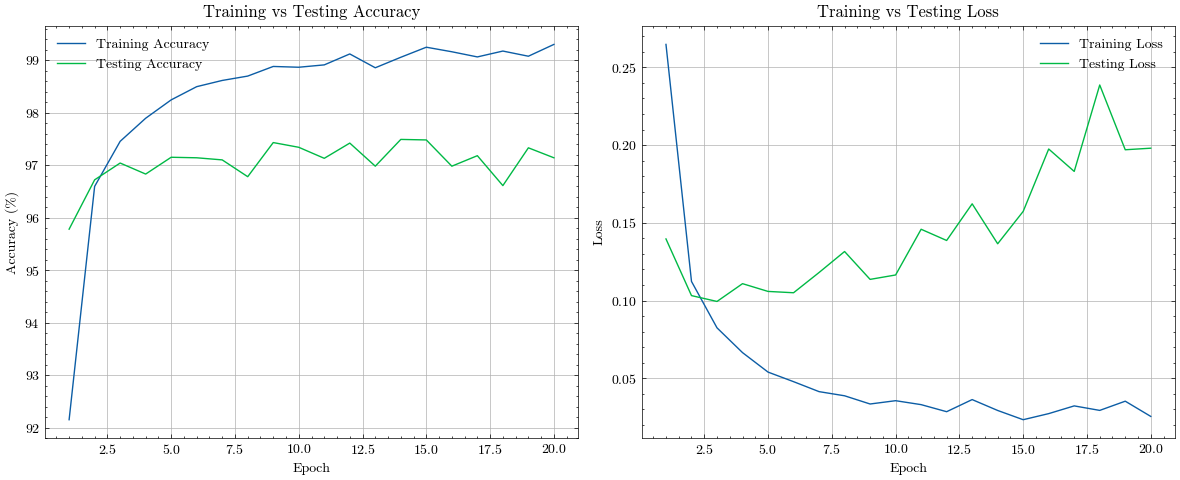

In [58]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies2, label = 'Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies2, label = 'Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses2, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses2, label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 

plt.tight_layout()
plt.show()

The overall performance is not bad: $>99\%$ of accuracy on the training and a decreasing loss. For testing, the accuracy is very high at the starting rpochs, but then it doesn't increase much, reaching anyway a good accuracy of $97\%$. The loss is more problematic, since it seems to be increasing after a few epochs. Methods such as early stopping could be introduced to avoid this.

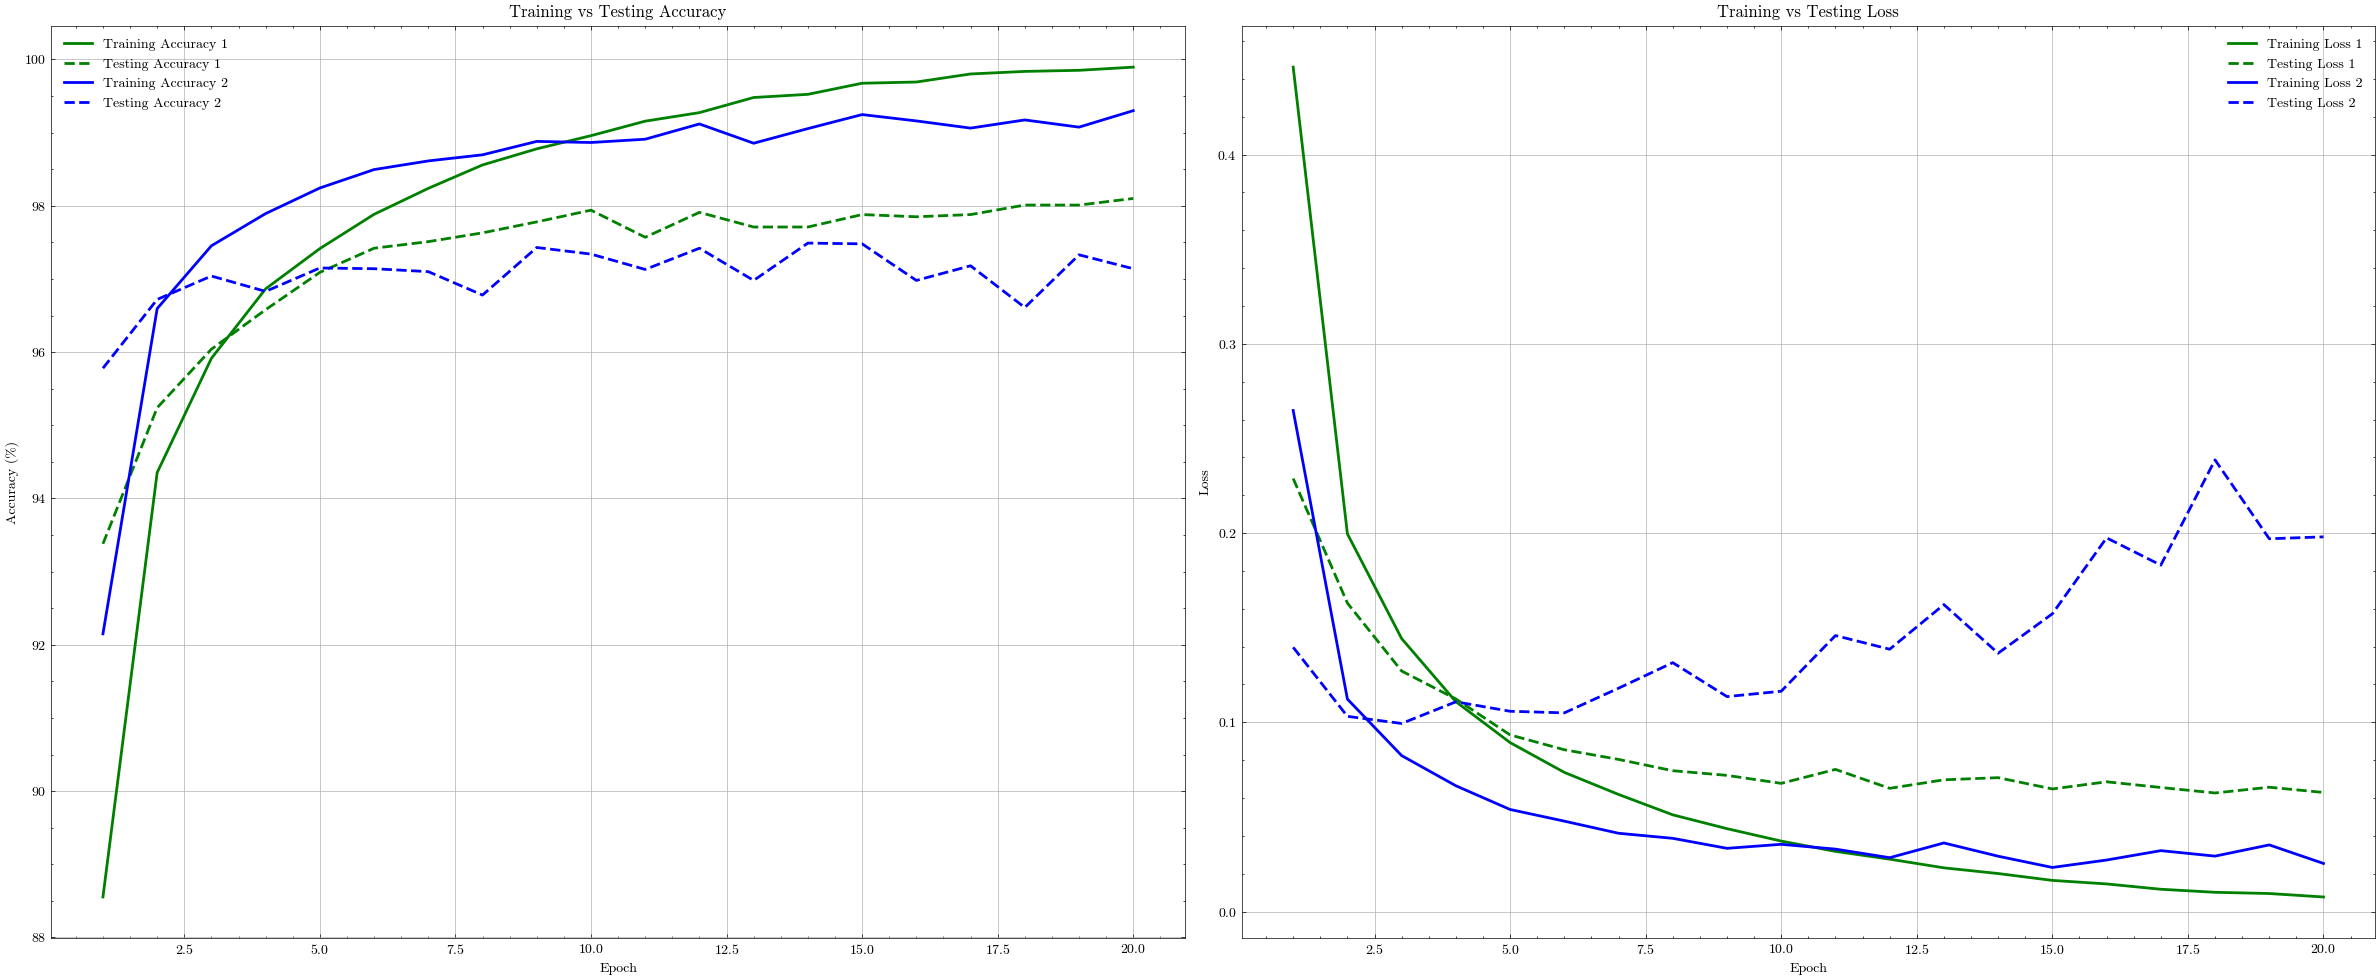

In [56]:
plt.style.use(['science','no-latex'])
epochs = len(train_accuracies) 

plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, 'g-', label='Training Accuracy 1', linewidth=2)
plt.plot(range(1, epochs + 1), test_accuracies, 'g--', label='Testing Accuracy 1', linewidth=2)
plt.plot(range(1, epochs + 1), train_accuracies2, 'b-', label='Training Accuracy 2', linewidth=2)
plt.plot(range(1, epochs + 1), test_accuracies2, 'b--', label='Testing Accuracy 2', linewidth=2)
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, 'g-', label='Training Loss 1', linewidth=2)
plt.plot(range(1, epochs + 1), test_losses, 'g--', label='Testing Loss 1', linewidth=2)
plt.plot(range(1, epochs + 1), train_losses2, 'b-', label='Training Loss 2', linewidth=2)
plt.plot(range(1, epochs + 1), test_losses2, 'b--', label='Testing Loss 2', linewidth=2)
plt.title('Training vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 

plt.tight_layout()
plt.show()

The final performance of the integrated model doesn't surpass the one of the shallow Neural Netowrk. However, it doesn't perform bad and it actually makes the first epochs better.